In [11]:
from pathlib import Path
from collections import Counter

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy.stats import ttest_ind

from utils import load_data

sns.set_style("whitegrid") # if you don't like the grid: `whitegrid` --> `white`
sns.set_context("paper", font_scale = 2)

In [6]:
# UniRef50 100k sample
u50_d = Path("../private/uniref50_051121_rnd100k")
u50_data = load_data(u50_d)
u50_data.insert(0, "type", "U50")

# ProtGPT2 100k generated
protgpt2_d = Path("../private/protGPT2_100k_maxL150_minPPL72")
protgpt2_data = load_data(protgpt2_d)
protgpt2_data.insert(0, "type", "ProtGPT2")

# Same sequences as in the 100k UniRef50 subset but with randomly shuffled sequences
# By only taking natural sequences and change their order, we keep length- and amino-acid-distributions
rnd_d = Path("../private/uniref50_rnd_shuffle")
rnd_data = load_data(rnd_d)
rnd_data.insert(0, "type", "Random")

# concatenate the dataframes
data = pd.concat([u50_data, protgpt2_data, rnd_data]).reset_index(drop=True)

# print columns that are currently available
print(f"These columns can be queried: {', '.join(data.columns.values)}")

No perplexity found in header. Skipping this field.
No perplexity found in header. Skipping this field.
These columns can be queried: type, header, sequence, length, disorder, disorder_categorical, disorder_average, disorder_count, disorder_percent, disorder_stretches, metal, metal_count, metal_percent, small, small_count, small_percent, nucleic, nucleic_count, nucleic_percent, conservation, conservation_categorical, conservation_high_count, conservation_high_percent, conservation_low_count, conservation_low_percent, dssp3, helix_count, helix_percent, strand_count, strand_percent, strand_stretch_count, helix_four_count, helix_four_percent, helix_stretch_count, BPO_reference, BPO_terms, BPO_distance, CCO_reference, CCO_terms, CCO_distance, MFO_reference, MFO_terms, MFO_distance, subcellular_location, CATH_reference, CATH_superfamily, CATH_distance, transmembrane, signal_residue_count, signal_protein, signal_residue_percent, transmembrane_helix_count, transmembrane_helix_percent, transme

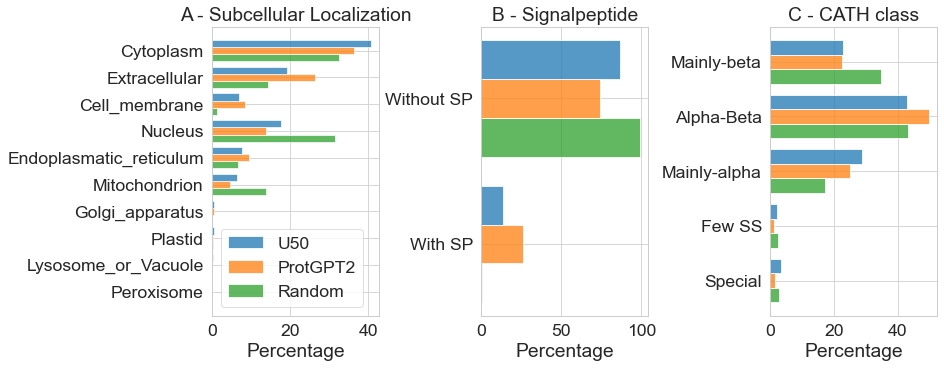

In [7]:
## Zoom into vertical bar-plots: subcell, SP, CATH

nrows=1
ncols=3
color_palette=sns.color_palette()
# adjust figure size by increasing figsize parameter
fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(13,5),constrained_layout=True)

# Subcellular location
g=sns.histplot(data=data,y="subcellular_location",hue="type",ax=ax[0],discrete=True,multiple="dodge", 
               shrink=.8,legend=True, stat="percent",common_norm=False)
ax[0].set_title("Subcellular Localization")
ax[0].get_legend().set_title(None)

# Signal peptides
# it suffices if a single residue is predicted to be a signal-peptide or not
sns.histplot(data=data,y="signal_protein",hue="type",ax=ax[1],discrete=True,multiple="dodge", 
             shrink=.8,legend=False, stat="percent",common_norm=False)
ax[1].set_title("Signalpeptide")

cath_mapping={"1":"Mainly-alpha","2":"Mainly-beta","3":"Alpha-Beta","4":"Few SS","6":"Special"}

cath_supFam_u50=[ cath_mapping[cath.split(".")[0]] for cath in u50_data.CATH_superfamily ]
cath_supFam_protgpt2=[ cath_mapping[cath.split(".")[0]] for cath in protgpt2_data.CATH_superfamily ]
cath_supFam_rnd=[ cath_mapping[cath.split(".")[0]] for cath in rnd_data.CATH_superfamily ]

df = pd.concat(axis=0, ignore_index=True, objs=[
    pd.DataFrame.from_dict({'value': cath_supFam_u50, 'type': 'U50'}),
    pd.DataFrame.from_dict({'value': cath_supFam_protgpt2, 'type': 'ProtGPT2'}),
    pd.DataFrame.from_dict({'value': cath_supFam_rnd, 'type': 'Random'})
])

sns.histplot(data=df, y="value", hue="type", ax=ax[2], discrete=True, multiple="dodge", 
             shrink=.8, legend=False, stat="percent",common_norm=False)
#sns.histplot(y=,ax=ax[2], discrete=True,color=color_palette[1], alpha=0.5,multiple="dodge", shrink=.8)
#ax[2].legend(labels=["U50","ProtGPT2", "Random"])
ax[2].set_title("CATH class")
# ax[2].get_legend().set_title(None)

panel_mapping={0:"A",1:"B",2:"C"}
for j in range(ncols):
    ax[j].set(xlabel="Percentage")
    ax[j].set(ylabel=None)
    ax[j].set_title( "{} - {}".format( panel_mapping[j], ax[j].get_title() ))

In [9]:
# Stretch analysis.
# Disorder
disorder_stretch_counter_u50=[ l for stretch_lens in u50_data.disorder_stretches for l in stretch_lens ]
disorder_stretch_counter_protgpt2=[ l for stretch_lens in protgpt2_data.disorder_stretches for l in stretch_lens ]
disorder_stretch_counter_rnd=[ l for stretch_lens in rnd_data.disorder_stretches for l in stretch_lens ]
disorder_df = pd.concat(axis=0, ignore_index=True, objs=[
    pd.DataFrame.from_dict({'value': disorder_stretch_counter_u50, 'type': 'U50'}),
    pd.DataFrame.from_dict({'value': disorder_stretch_counter_protgpt2, 'type': 'ProtGPT2'}),
    pd.DataFrame.from_dict({'value': disorder_stretch_counter_rnd, 'type' : "Random"})
])

# TM-strands
tm_strand_stretch_count_u50=[ l for stretch_lens in u50_data.transmembrane_strand_stretches for l in stretch_lens ]
tm_strand_stretch_count_protgpt2=[ l for stretch_lens in protgpt2_data.transmembrane_strand_stretches for l in stretch_lens ]
tm_strand_stretch_count_rnd=[ l for stretch_lens in rnd_data.transmembrane_strand_stretches for l in stretch_lens ]
tm_strand_stretch_df = pd.concat(axis=0, ignore_index=True, objs=[
    pd.DataFrame.from_dict({'value': tm_strand_stretch_count_u50, 'type': 'U50'}),
    pd.DataFrame.from_dict({'value': tm_strand_stretch_count_protgpt2, 'type': 'ProtGPT2'}),
    pd.DataFrame.from_dict({'value': tm_strand_stretch_count_rnd, 'type': 'Random'})
])

# TM-helices
tm_helix_stretch_count_u50=[ l for stretch_lens in u50_data.transmembrane_helix_stretches for l in stretch_lens ]
tm_helix_stretch_count_protgpt2=[ l for stretch_lens in protgpt2_data.transmembrane_helix_stretches for l in stretch_lens ]
tm_helix_stretch_count_rnd=[ l for stretch_lens in rnd_data.transmembrane_helix_stretches for l in stretch_lens ]
tm_helix_stretch_df = pd.concat(axis=0, ignore_index=True, objs=[
    pd.DataFrame.from_dict({'value': tm_helix_stretch_count_u50, 'type': 'U50'}),
    pd.DataFrame.from_dict({'value': tm_helix_stretch_count_protgpt2, 'type': 'ProtGPT2'}),
    pd.DataFrame.from_dict({'value': tm_helix_stretch_count_rnd, 'type': 'Random'})
])

# Strands
strand_stretch_count_u50=[ l for stretch_lens in u50_data.strand_stretch_count for l in stretch_lens ]
strand_stretch_count_protgpt2=[ l for stretch_lens in protgpt2_data.strand_stretch_count for l in stretch_lens ]
strand_stretch_count_rnd=[ l for stretch_lens in rnd_data.strand_stretch_count for l in stretch_lens ]
strand_stretch_df = pd.concat(axis=0, ignore_index=True, objs=[
    pd.DataFrame.from_dict({'value': strand_stretch_count_u50, 'type': 'U50'}),
    pd.DataFrame.from_dict({'value': strand_stretch_count_protgpt2, 'type': 'ProtGPT2'}),
    pd.DataFrame.from_dict({'value': strand_stretch_count_rnd, 'type': 'Random'})
])

# Helices
helix_stretch_count_50=[ l for stretch_lens in u50_data.helix_stretch_count for l in stretch_lens ]
helix_stretch_count_protgpt2=[ l for stretch_lens in protgpt2_data.helix_stretch_count for l in stretch_lens ]
helix_stretch_count_rnd=[ l for stretch_lens in rnd_data.helix_stretch_count for l in stretch_lens ]
helix_stretch_df = pd.concat(axis=0, ignore_index=True, objs=[
    pd.DataFrame.from_dict({'value': helix_stretch_count_50, 'type': 'U50'}),
    pd.DataFrame.from_dict({'value': helix_stretch_count_protgpt2, 'type': 'ProtGPT2'}),
    pd.DataFrame.from_dict({'value': helix_stretch_count_rnd, 'type': 'Random'})
])

print("Finished parsing stretch data")

Finished parsing stretch data


Performing t-Test (default scipy-parameters assuming two independent distributions:):
P-value for tm_strand (Random vs U50): 3.3565868120065416e-305
P-value for tm_strand (Random vs ProtGPT2): 0.0
P-value for tm_strand (U50 vs ProtGPT2): 4.662680333123702e-09
P-value for tm_helix (Random vs U50): 0.0
P-value for tm_helix (Random vs ProtGPT2): 0.0
P-value for tm_helix (U50 vs ProtGPT2): 9.231967562284227e-06
P-value for strand_stretch (Random vs U50): 0.0
P-value for strand_stretch (Random vs ProtGPT2): 0.0
P-value for strand_stretch (U50 vs ProtGPT2): 3.4889708348041437e-06
P-value for helix_stretch (Random vs U50): 0.0
P-value for helix_stretch (Random vs ProtGPT2): 0.0
P-value for helix_stretch (U50 vs ProtGPT2): 7.683744817548967e-195
P-value for disorder (Random vs U50): 4.694954654706905e-32
P-value for disorder (Random vs ProtGPT2): 2.6307256622616662e-74
P-value for disorder (U50 vs ProtGPT2): 1.6129332993581633e-10


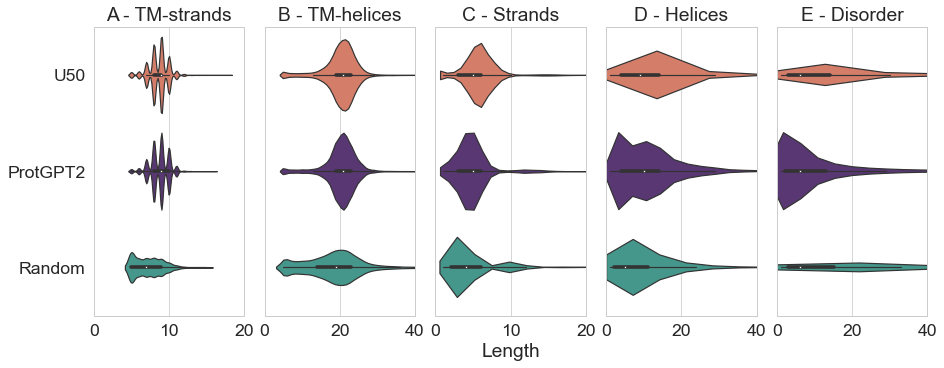

In [15]:
## Zoom into stretch length distribution: helix, sheet, TM-helix, TM-sheet, disorder (CheZOD<=8)
nrows=1
ncols=5
color_palette=sns.color_palette()
plot='violin'
fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(13,5),constrained_layout=True,
                       sharey=True if plot == 'violin' else False)
stat="count" # either of: count frequency probability proportion percent density
multiple="stack" # either of (for "stack", stat has to be count as percentage can be >100 otherwise):  “layer”, “dodge”, “stack”, “fill”
p_val=True
my_pal = {"U50": "#e67358", "ProtGPT2": "#592d7d", "Random": "#39a495"}


if plot == 'hist':
    sns.histplot(
        data=tm_strand_stretch_df, x="value", hue="type", ax=ax[0],legend=False,
        discrete=True,stat=stat,common_norm=False, multiple=multiple
    )
    sns.histplot(
        data=tm_helix_stretch_df, x="value", hue="type", ax=ax[1],legend=False,
        discrete=True,stat=stat,common_norm=False, multiple=multiple
    )
    sns.histplot(
        data=strand_stretch_df, x="value", hue="type",ax=ax[2],legend=False,
        discrete=True,stat=stat,common_norm=False, multiple=multiple
    )
    sns.histplot(
        data=helix_stretch_df, x="value", hue="type",ax=ax[3],legend=False,
        discrete=True,stat=stat,common_norm=False, multiple=multiple
    )
    sns.histplot(
        data=disorder_df, x="value", hue="type", ax=ax[4],legend=True,
        discrete=True,stat=stat,common_norm=False, multiple=multiple
    )
    
    
elif plot == 'kde':
    sns.kdeplot(data=tm_strand_stretch_df, x="value", hue="type", ax=ax[0], legend=False)
    sns.kdeplot(data=tm_helix_stretch_df, x="value", hue="type", ax=ax[1], legend=False)
    sns.kdeplot(data=strand_stretch_df, x="value", hue="type", ax=ax[2], legend=False)
    sns.kdeplot(data=helix_stretch_df, x="value", hue="type", ax=ax[3], legend=False)
    sns.kdeplot(data=disorder_df, x="value", hue="type", ax=ax[4], legend=True)
elif plot == 'violin':
    sns.violinplot(data=tm_strand_stretch_df, x="value", y="type", ax=ax[0], palette=my_pal)
    sns.violinplot(data=tm_helix_stretch_df, x="value", y="type", ax=ax[1], palette=my_pal)
    sns.violinplot(data=strand_stretch_df, x="value", y="type", ax=ax[2], palette=my_pal)
    sns.violinplot(data=helix_stretch_df, x="value", y="type", ax=ax[3], palette=my_pal)
    sns.violinplot(data=disorder_df, x="value", y="type", ax=ax[4], palette=my_pal)

if p_val:

    print("Performing t-Test (default scipy-parameters assuming two independent distributions:):")
    for feature_name, feature_set in {"tm_strand": tm_strand_stretch_df,
                                      "tm_helix" : tm_helix_stretch_df,
                                      "strand_stretch":strand_stretch_df,
                                      "helix_stretch":helix_stretch_df,
                                      "disorder":disorder_df
                                    }.items():
        # t-Test: Random vs U50
        U1, p = ttest_ind( feature_set.loc[feature_set["type"] == "Random"]["value"].values, 
                                feature_set.loc[ feature_set["type"] == "U50"]["value"].values
                        )
        print("P-value for {} ({} vs {}): {}".format(feature_name, "Random", "U50", p))
        
        # t-Test: Random vs ProtGPT2
        U1, p = ttest_ind( feature_set.loc[feature_set["type"] == "Random"]["value"].values, 
                                feature_set.loc[ feature_set["type"] == "ProtGPT2"]["value"].values
                        )
        print("P-value for {} ({} vs {}): {}".format(feature_name, "Random", "ProtGPT2", p))
        
        # t-Test: U50 vs ProtGPT2
        U1, p = ttest_ind( feature_set.loc[feature_set["type"] == "U50"]["value"].values, 
                                feature_set.loc[ feature_set["type"] == "ProtGPT2"]["value"].values
                        )
        print("P-value for {} ({} vs {}): {}".format(feature_name, "U50", "ProtGPT2", p))

if plot != 'violin':
    ax[4].get_legend().set_title(None)

header={0 : "A - TM-strands",
        1 : "B - TM-helices",
        2 : "C - Strands",
        3 : "D - Helices",
        4 : "E - Disorder"
       }

for j in range(ncols):
    ax[j].set(xlabel="Length")
    xlim=20 if j==0 or j==2 else 40
    
    if plot == 'hist':
        ax[j].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'K'))
    
    ax[j].set(xlim=(0,xlim))
    ax[j].set_title(header[j])
    if plot != 'violin':
        if j==0: # set y-axis only for left-most panel
            ax[j].set(ylabel=stat)
        else:
            ax[j].set(ylabel=None)
    else:
        ax[j].set(ylabel=None)
    
    if j==2: # set x-axis only for middle
        ax[j].set(xlabel="Length")
    else:
        ax[j].set(xlabel=None)

P-value for CCO_distance (Random vs U50): 1.3702091883200452e-227
P-value for CCO_distance (Random vs ProtGPT2): 5.32432137249012e-15
P-value for CCO_distance (U50 vs ProtGPT2): 4.9857659254719735e-264
P-value for BPO_distance (Random vs U50): 0.0
P-value for BPO_distance (Random vs ProtGPT2): 0.11273526114488426
P-value for BPO_distance (U50 vs ProtGPT2): 1.8957577485674177e-240
P-value for MFO_distance (Random vs U50): 0.0
P-value for MFO_distance (Random vs ProtGPT2): 3.642138036384282e-12
P-value for MFO_distance (U50 vs ProtGPT2): 1.1186439030685259e-160
P-value for CATH_distance (Random vs U50): 0.0
P-value for CATH_distance (Random vs ProtGPT2): 0.0
P-value for CATH_distance (U50 vs ProtGPT2): 1.2602587569573145e-08


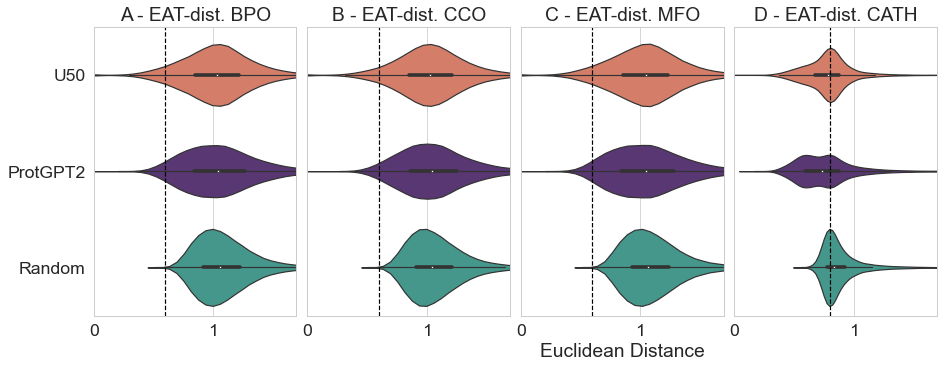

In [27]:
## Zoom into distance to nearest neighbor in embedding space using Euclidean distance (EAT; embedding-based Annotation Transfer)
nrows=1
ncols=4
color_palette=sns.color_palette()
plot='violin'
fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(13,5),constrained_layout=True,
                       sharey=True if plot == 'violin' else False)
hist=False
p_val=True
my_pal = {"U50": "#e67358", "ProtGPT2": "#592d7d", "Random": "#39a495"}

if plot == 'hist':
    sns.histplot(data=data,x="BPO_distance",hue="type",ax=ax[0],bins=100, legend=False,
                 kde=True, stat="percent",common_norm=False, fill=False, element="step")
    sns.histplot(data=data,x="CCO_distance",hue="type",ax=ax[1],bins=100, legend=False,
                 kde=True, stat="percent",common_norm=False, fill=False, element="step")
    sns.histplot(data=data,x="MFO_distance",hue="type",ax=ax[2],bins=100, legend=False,
                 kde=True, stat="percent",common_norm=False, fill=False, element="step")
    sns.histplot(data=data,x="CATH_distance",hue="type",ax=ax[3],bins=100, legend=True,
                 kde=True, stat="percent",common_norm=False, fill=False, element="step")
elif plot == 'kde':
    sns.kdeplot(data=data,x="BPO_distance",hue="type",ax=ax[0], legend=False)
    sns.kdeplot(data=data,x="CCO_distance",hue="type",ax=ax[1], legend=False)
    sns.kdeplot(data=data,x="MFO_distance",hue="type",ax=ax[2], legend=False)
    sns.kdeplot(data=data,x="CATH_distance",hue="type",ax=ax[3], legend=True)
elif plot == 'violin':
    sns.violinplot(data=data,x="BPO_distance",y="type",ax=ax[0], palette=my_pal)
    sns.violinplot(data=data,x="CCO_distance",y="type",ax=ax[1], palette=my_pal)
    sns.violinplot(data=data,x="MFO_distance",y="type",ax=ax[2], palette=my_pal)
    sns.violinplot(data=data,x="CATH_distance",y="type",ax=ax[3], palette=my_pal)

if plot != 'violin':
    ax[3].get_legend().set_title(None)

ax[0].axvline(x=0.6, color='black', label='Threshold', ls='--')
ax[1].axvline(x=0.6, color='black', label='Threshold', ls='--')
ax[2].axvline(x=0.6, color='black', label='Threshold', ls='--')
ax[3].axvline(x=0.8, color='black', label='Threshold', ls='--')

if p_val:
    for feature_name in {"BPO_distance","CCO_distance","MFO_distance","CATH_distance"}:
        # t-Test: Random vs U50
        U1, p = ttest_ind( data.loc[data["type"] == "Random"][feature_name].values, 
                                data.loc[data["type"] == "U50"][feature_name].values
                        )
        print("P-value for {} ({} vs {}): {}".format(feature_name, "Random", "U50", p))
        
        # t-Test: Random vs ProtGPT2
        U1, p = ttest_ind( data.loc[data["type"] == "Random"][feature_name].values, 
                                data.loc[data["type"] == "ProtGPT2"][feature_name].values
                        )
        print("P-value for {} ({} vs {}): {}".format(feature_name, "Random", "ProtGPT2", p))
        
        # t-Test: U50 vs ProtGPT2
        U1, p = ttest_ind( data.loc[data["type"] == "U50"][feature_name].values, 
                                data.loc[data["type"] == "ProtGPT2"][feature_name].values
                        )
        print("P-value for {} ({} vs {}): {}".format(feature_name, "U50", "ProtGPT2", p))


header={0 : "A - EAT-dist. BPO",
        1 : "B - EAT-dist. CCO",
        2 : "C - EAT-dist. MFO",
        3 : "D - EAT-dist. CATH",
       }

for j in range(ncols):

    ax[j].set(xlim=(0,1.7))
    ax[j].set_title(header[j])
    
    if j==0: # set y-axis only for left-most panel
        if plot == 'hist':
            ax[j].set(ylabel="Percentage")
        elif plot == 'kde':
            ax[j].set(ylabel="Density")
        elif plot == 'violin':
            ax[j].set(ylabel=None)
    else:
        ax[j].set(ylabel=None)
    
    if j==2: # set x-axis only for middle
        ax[j].set(xlabel="Euclidean Distance")
    else:
        ax[j].set(xlabel=None)

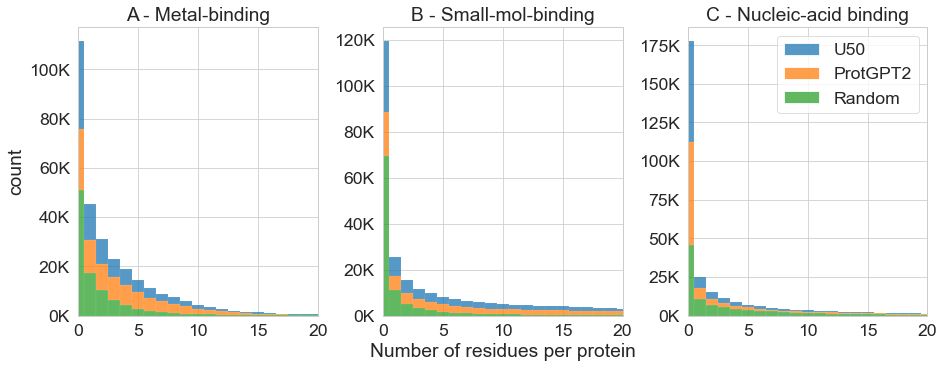

In [30]:
## Zoom into binding residues
nrows=1
ncols=3
color_palette=sns.color_palette()
fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(13,5),constrained_layout=True)
hist=True
stat="count" # either of: count frequency probability proportion percent density
multiple="stack" # either of (for "stack", stat has to be count as percentage can be >100 otherwise):  “layer”, “dodge”, “stack”, “fill”

# Binding
if hist:
    sns.histplot(data=data,x="metal_count",hue="type",ax=ax[0],legend=False,
                 discrete=True,stat=stat,common_norm=False, multiple=multiple)
    sns.histplot(data=data,x="small_count",hue="type",ax=ax[1],legend=False,
                 discrete=True,stat=stat,common_norm=False, multiple=multiple)
    sns.histplot(data=data,x="nucleic_count",hue="type",ax=ax[2],legend=True,
                 discrete=True,stat=stat,common_norm=False, multiple=multiple)
else:
    sns.kdeplot(data=data,x="metal_count",hue="type",ax=ax[0],legend=False)
    sns.kdeplot(data=data,x="small_count",hue="type",ax=ax[1],legend=False)
    sns.kdeplot(data=data,x="nucleic_count",hue="type",ax=ax[2],legend=True)
    

ax[2].get_legend().set_title(None)

header={0 : "A - Metal-binding",
        1 : "B - Small-mol-binding",
        2 : "C - Nucleic-acid binding",
       }

for j in range(ncols):
    # if you want to avoid that proteins without any binding site are considered, set the following to xlim=(1,30)
    
    if hist:
        ax[j].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'K'))
    
    
    ax[j].set(xlim=(0,20))
    ax[j].set_title(header[j])
    if j==0: # set y-axis only for left-most panel
        ax[j].set(ylabel=stat)
    else:
        ax[j].set(ylabel=None)
    
    if j==1: # set x-axis only for middle
        ax[j].set(xlabel="Number of residues per protein")
    else:
        ax[j].set(xlabel=None)

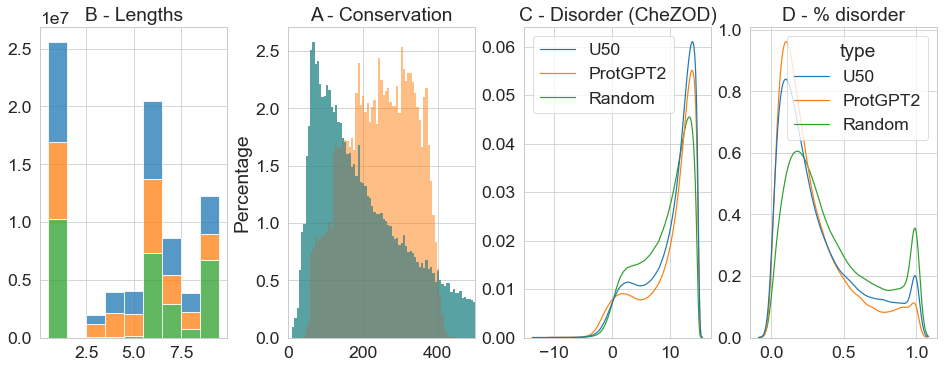

In [57]:
## Sequence length, conservation and disorder (CheZOD), disorder (%)
nrows=1
ncols=4
color_palette=sns.color_palette()
fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(13,5),constrained_layout=True)
hist=False


# Look into conservation
conservation_raw=[ int(cons) for cons_list in data.conservation for cons in cons_list]
# Next, we zoom into disorder:
# flatten the list-of-lists to make it seaborn compatible
conservation_u50=[ int(cons)+1 for cons_list in u50_data.conservation for cons in cons_list]
conservation_protgpt2=[ int(cons)+1 for cons_list in protgpt2_data.conservation for cons in cons_list]
conservation_rnd=[ int(cons)+1 for cons_list in rnd_data.conservation for cons in cons_list]
conservation_df = pd.concat(axis=0, ignore_index=True, objs=[
    pd.DataFrame.from_dict({'value': conservation_u50, 'type': 'U50'}),
    pd.DataFrame.from_dict({'value': conservation_protgpt2, 'type': 'ProtGPT2'}),
    pd.DataFrame.from_dict({'value': conservation_rnd, 'type': 'Random'})
])


sns.histplot(conservation_df, x="value", hue="type",ax=ax[0],discrete=True,legend=False,
             stat=stat,common_norm=False, multiple="stack")

sns.histplot(data=data, x="length", hue="type", ax=ax[1],legend=False,stat="percent",common_norm=False)


# Next, we zoom into disorder:
# flatten the list-of-lists to make it seaborn compatible
disorder_raw_u50=[ chezod for chezod_list in u50_data.disorder for chezod in chezod_list]
disorder_raw_protgpt2=[ chezod for chezod_list in protgpt2_data.disorder for chezod in chezod_list]
disorder_raw_rnd=[ chezod for chezod_list in rnd_data.disorder for chezod in chezod_list]
disorder_raw_df = pd.concat(axis=0, ignore_index=True, objs=[
    pd.DataFrame.from_dict({'value': disorder_raw_u50, 'type': 'U50'}),
    pd.DataFrame.from_dict({'value': disorder_raw_protgpt2, 'type': 'ProtGPT2'}),
    pd.DataFrame.from_dict({'value': disorder_raw_rnd, 'type': 'Random'}),
])
if hist:
    sns.histplot(disorder_raw_df,x="value", hue="type", ax=ax[2],bins=30, legend=True,
                 stat="percent",common_norm=False,fill=True)
    sns.histplot(data=data,x="disorder_percent",hue="type", ax=ax[3],bins=30,legend=False,
                 stat="percent",common_norm=False,fill=True)
else:
    sns.kdeplot(data=disorder_raw_df,x="value",hue="type",ax=ax[2], legend=True)
    sns.kdeplot(data=data,x="disorder_percent",hue="type",ax=ax[3], legend=False)
ax[2].get_legend().set_title(None)

header={
        1 : "A - Conservation",
        0 : "B - Lengths",
        2 : "C - Disorder (CheZOD)",
        3 : "D - % disorder"
       }

for j in range(ncols):
    ax[j].set_title(header[j])
    if j==0: # set y-axis only for left-most panel
        ax[j].set(ylabel="Count")
    elif j==1:
        ax[j].set(ylabel="Percentage")
        ax[j].set(xlim=(0,500)) # max seq len 500
    elif j==2:
        ax[j].set(ylabel="Density")
    else:
        ax[j].set(ylabel=None)
        
    ax[j].set(xlabel=None)

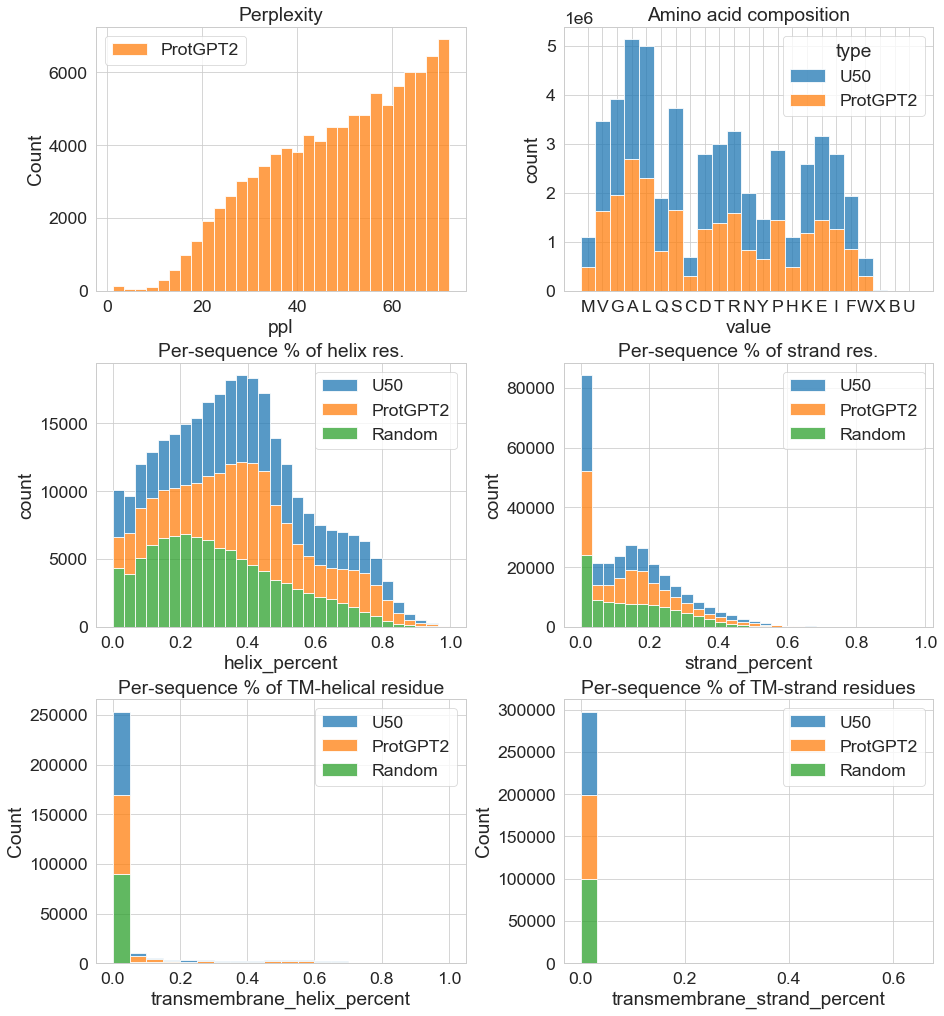

In [6]:
# Currently un-used plots - Not sure whether those will be relevant at all

nrows=3
ncols=2
color_palette=sns.color_palette()
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13,14), constrained_layout=True)

stat="count" # either of: count frequency probability proportion percent density
multiple="stack" # either of (for "stack", stat has to be count as percentage can be >100 otherwise):  “layer”, “dodge”, “stack”, “fill”

# Perplexity
if "ppl" in data.columns.values: # ensure that ProtGPT2 has always the same color throughout the notebook
    sns.histplot(data=data, x="ppl", ax=ax[0,0], bins=30,color=color_palette[1])
    ax[0,0].set_title("Perplexity")
    ax[0,0].legend(labels=["ProtGPT2"])
    
    
# Next, we zoom into amino acid composition:
# flatten the list-of-lists to make it seaborn compatible
aa_u50 = [ aa for seq in u50_data.sequence for aa in seq]
aa_protgpt2 = [ aa for seq in protgpt2_data.sequence for aa in seq]
aa_rnd = [ aa for seq in rnd_data.sequence for aa in seq]

aa_df = pd.concat(axis=0, ignore_index=True, objs=[
    pd.DataFrame.from_dict({'value': aa_u50, 'type': 'U50'}),
    pd.DataFrame.from_dict({'value': aa_protgpt2, 'type': 'ProtGPT2'}),
    # Adding random here does not make much sense as I enforced it to have the same AA-distribution as the U50 set
    #pd.DataFrame.from_dict({'value': aa_rnd, 'type': 'Random'}),
])

sns.histplot(aa_df,x="value", hue="type", ax=ax[0,1],legend=True, discrete=True,
             stat=stat,common_norm=False,multiple=multiple)
ax[0,1].set_title("Amino acid composition")
ax[0,1].set(ylabel=stat)

# Let's analyze some structural aspects of our protein set
# Secondary structure
sns.histplot(data=data,x="helix_percent", hue="type",ax=ax[1,0],bins=30,
             stat=stat,common_norm=False,multiple=multiple)
ax[1,0].set_title("Per-sequence % of helix res.")
ax[1,0].get_legend().set_title(None)
ax[1,0].set(ylabel=stat)

sns.histplot(data=data,x="strand_percent",hue="type",ax=ax[1,1],bins=30,
             stat=stat,common_norm=False, multiple=multiple)
ax[1,1].set_title("Per-sequence % of strand res.")
ax[1,1].get_legend().set_title(None)
ax[1,1].set(ylabel=stat)

# Secondary structure transmembrane
sns.histplot(data=data,x="transmembrane_helix_percent",hue="type",ax=ax[2,0],
             stat=stat,common_norm=False,multiple=multiple)
ax[2,0].set_title("Per-sequence % of TM-helical residue")
ax[2,0].get_legend().set_title(None)

sns.histplot(data=data,x="transmembrane_strand_percent",hue="type",ax=ax[2,1],
             stat=stat,common_norm=False,multiple=multiple)
ax[2,1].set_title("Per-sequence % of TM-strand residues")
ax[2,1].get_legend().set_title(None)